# temps de debut execution

In [96]:
import time
import datetime

# Marquer le début de l'exécution
start_time = time.time()
print(f"Exécution du notebook commencée à: {datetime.datetime.now()}")


Exécution du notebook commencée à: 2024-06-29 15:23:13.316255


# Préparation des données

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import joblib
import os

# Configurer MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Credit Risk Model")

# Charger le DataFrame
app_datas = pd.read_csv('../csv_files/app_datas_light.csv')

# Mode débogage
debug_mode = True

if debug_mode:
    # Utiliser un sous-ensemble du dataset pour le débogage
    app_datas = app_datas.sample(frac=0.01, random_state=42)

# sauvegarde des identifiants clients
customer_id = app_datas['SK_ID_CURR']

# Séparer les features et la cible
X = app_datas.drop(columns=['SK_ID_CURR', 'TARGET'])
y = app_datas['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Créer un pipeline avec imputation KNN, standardisation et SMOTE
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler()),  # Standardisation des caractéristiques
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42))  # Équilibrage des classes avec SMOTE
])

# Appliquer le pipeline sur les données d'entraînement
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Transformer les données de test sans SMOTE
X_test_imputed = pipeline.named_steps['imputer'].transform(X_test)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test_imputed)

# création d'un dataframe imputed et scaled pour la prédiction dans l'aPI

# Utiliser les étapes d'imputation et de standardisation du pipeline existant
imputerAPI = pipeline.named_steps['imputer']
scalerAPI = pipeline.named_steps['scaler']

app_datas_to_use = app_datas.drop(columns=['SK_ID_CURR', 'TARGET'])

# Appliquer l'imputation et la standardisation sur le DataFrame
app_datas_imputed = imputerAPI.transform(app_datas_to_use)
app_datas_scaled = scalerAPI.transform(app_datas_imputed)

# Convertir le résultat en DataFrame et conserver les colonnes originales
app_datas_imputed_scaled = pd.DataFrame(app_datas_scaled, columns=app_datas_to_use.columns)

# Remettre la colonne 'TARGET' dans le DataFrame
app_datas_imputed_scaled['TARGET'] = target.values

# Remettre la colonne 'SK_ID_CURR' dans le dataframe
app_datas_imputed_scaled['SK_ID_CURR'] = customer_id.values

# Sauvegarder le DataFrame résultant dans un fichier CSV
app_datas_imputed_scaled.to_csv('../csv_files/app_datas_light_imputed_scaled.csv', index=False)


print(f"Shape of X_train: {X_train_resampled.shape}")
print(f"Shape of X_test: {X_test_scaled.shape}")
print(f"Distribution in y_train: {pd.Series(y_train_resampled).value_counts(normalize=True)}")
print(f"Distribution in y_test: {pd.Series(y_test).value_counts(normalize=True)}")


Shape of X_train: (2943, 239)
Shape of X_test: (615, 239)
Distribution in y_train: TARGET
0    0.769283
1    0.230717
Name: proportion, dtype: float64
Distribution in y_test: TARGET
0    0.920325
1    0.079675
Name: proportion, dtype: float64


In [98]:
app_datas_imputed_scaled.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,TARGET,SK_ID_CURR
0,-0.319610,-0.687789,-1.498460,-0.577726,-0.571904,-0.270974,-0.046302,-0.130514,1.055479,-0.094078,...,-0.080911,-0.060597,-0.549797,-0.512673,-0.138042,-1.062953,-0.088225,-0.471229,0,368274
1,3.128813,-0.687789,0.667352,-0.577726,-0.346484,-0.821934,-0.912962,-0.730145,-0.464263,0.064644,...,-0.080911,-0.060597,-0.549797,-0.512673,-0.138042,-1.062953,-0.088225,-0.471229,0,141653
2,-0.319610,1.453934,-1.498460,0.807465,-0.797324,-0.678684,-0.699768,-0.574241,-0.200709,-1.224576,...,-0.080911,-0.060597,1.818854,-0.512673,-0.138042,0.940775,-0.088225,-0.471229,0,289560
3,-0.319610,-0.687789,0.667352,0.807465,-0.346484,-0.257685,0.171520,-0.298411,-0.885421,-0.811989,...,-0.080911,-0.060597,-0.549797,1.950561,-0.138042,0.940775,-0.088225,-0.471229,0,256074
4,-0.319610,1.453934,-1.498460,0.807465,0.149439,0.169795,0.306611,0.349191,-0.784901,-1.123945,...,-0.080911,-0.060597,-0.549797,1.950561,-0.138042,0.940775,-0.088225,-0.471229,0,396861


In [99]:
print(app_datas.shape)
print(app_datas.columns)

print(app_datas_imputed_scaled.shape)
print(app_datas_imputed_scaled.columns)

(3075, 241)
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'TARGET',
       'DAYS_EMPLOYED_ANOM'],
      dtype='object', length=241)
(3075, 241)
Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
    

# Modélisation

## fonction model

In [100]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

def evaluate_and_log_model(model, model_name, model_type, params, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Prédictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn

        # Logger les métriques et les hyperparamètres
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        mlflow.log_params(params)
        mlflow.log_param("model_type", model_type)
        
        # Enregistrer le modèle
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"{model_name} - AUC: {auc}")
        print(f"{model_name} - Accuracy: {accuracy}")
        print(f"{model_name} - Cost: {cost}")


## Modèle Dummy

In [101]:
from sklearn.dummy import DummyClassifier

dummy_params = {"strategy": "most_frequent"}
dummy_clf = DummyClassifier(**dummy_params)
evaluate_and_log_model(dummy_clf, "dummy_classifier_model", "Dummy Classifier", dummy_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


dummy_classifier_model - AUC: 0.5
dummy_classifier_model - Accuracy: 0.9203252032520325
dummy_classifier_model - Cost: 490


## Modèle Regression lineaire

In [102]:
from sklearn.linear_model import LogisticRegression

log_reg_params = {
    "penalty": 'l2',
    "C": 1.0,
    "class_weight": 'balanced',
    "random_state": 42,
    "max_iter": 1000
}
log_reg = LogisticRegression(**log_reg_params)
evaluate_and_log_model(log_reg, "logistic_regression_model", "Logistic Regression", log_reg_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


logistic_regression_model - AUC: 0.6004182591764621
logistic_regression_model - Accuracy: 0.7170731707317073
logistic_regression_model - Cost: 417


## Modèle Random Forrest

In [103]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": 100,
    "class_weight": 'balanced',
    "random_state": 42
}
rf_clf = RandomForestClassifier(**rf_params)
evaluate_and_log_model(rf_clf, "random_forest_model", "Random Forest", rf_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


random_forest_model - AUC: 0.6386745510925218
random_forest_model - Accuracy: 0.9186991869918699
random_forest_model - Cost: 491


## Modèle XGBoost

In [104]:
from xgboost import XGBClassifier

xgb_params = {
    "objective": 'binary:logistic',
    "random_state": 42,
    "eval_metric": 'auc'
}
xgb_clf = XGBClassifier(**xgb_params)
evaluate_and_log_model(xgb_clf, "xgboost_model", "XGBoost", xgb_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


xgboost_model - AUC: 0.6149131030504075
xgboost_model - Accuracy: 0.9138211382113821
xgboost_model - Cost: 476


## création du score personnalisé

In [105]:
from sklearn.metrics import make_scorer, confusion_matrix

# Définir une fonction pour calculer le coût
def custom_cost(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn
    return cost

# Créer un make_scorer à partir de la fonction custom_cost
cost_scorer = make_scorer(custom_cost, greater_is_better=False)


## Gridsearchcv sur XGBOost et log mlflow

In [106]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# Définir les hyperparamètres à tester
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300]
}

# Créer le modèle XGBoost
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# Configurer GridSearchCV avec le score personnalisé
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=cost_scorer, cv=3, verbose=2, n_jobs=-1)

# Fonction pour évaluer et enregistrer les résultats de GridSearchCV dans MLflow
def log_grid_search_cv_results(grid_search, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Loguer le type de modèle
        mlflow.log_param("model_type", "XGBoost with GridSearchCV")
        
        # Entraîner le GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Logger tous les résultats de GridSearchCV
        cv_results = pd.DataFrame(grid_search.cv_results_)
        for i in range(len(cv_results)):
            for key in cv_results.columns:
                value = cv_results[key].iloc[i]
                if isinstance(value, (float, int, np.number)):
                    mlflow.log_metric(f"{key}_{i}", value)
                elif isinstance(value, (list, dict)):
                    # Convert lists or dicts to a string representation
                    mlflow.log_param(f"{key}_{i}", str(value))
        
        # Enregistrer les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
       
        
        # Afficher les meilleurs hyperparamètres
        print("Best Hyperparameters:", best_params)
        
        # Enregistrer le meilleur modèle
        best_model = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_model, "best_xgboost_model")

        # Sauvegarder le modèle localement dans le dossier 'models'
        model_path = '../models/best_xgboost_model.pkl'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(best_model, model_path)
        print(f"Best model saved to {model_path}")
        
        # Prédictions avec le meilleur modèle
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn
        
        # Logger les métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        
        print(f"Best Model - AUC: {auc}")
        print(f"Best Model - Accuracy: {accuracy}")
        print(f"Best Model - Cost: {cost}")

# Exécuter la fonction pour loguer les résultats de GridSearchCV
log_grid_search_cv_results(grid_search, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300}
Best model saved to ../models/best_xgboost_model.pkl
Best Model - AUC: 0.6814379462032162
Best Model - Accuracy: 0.9235772357723577
Best Model - Cost: 452


## GridSearchCV avec Pipelines

L'intégration de pipelines dans le processus de GridSearch présente plusieurs avantages, notamment la simplification du flux de travail, l'élimination des fuites de données et l'automatisation des étapes de prétraitement. Voici comment et pourquoi vous pouvez intégrer des pipelines dans votre code de GridSearch.
Avantages de l'Intégration de Pipelines

    Simplification du Flux de Travail :
        En intégrant les étapes de prétraitement et de modélisation dans un pipeline, le code devient plus propre et plus facile à comprendre.

    Élimination des Fuites de Données :
        Lors de la validation croisée, il est crucial que les étapes de prétraitement soient ajustées uniquement sur les données d'entraînement et non sur les données de validation. Les pipelines assurent cette séparation.

    Automatisation et Reproductibilité :
        Les pipelines permettent d'automatiser l'ensemble du processus, garantissant que chaque étape est exécutée de manière cohérente. Cela rend également le processus reproductible.

In [107]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import os
import joblib

# Définir les étapes du pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardiser les données
    ('xgb', XGBClassifier(objective='binary:logistic', random_state=42))
])

# Définir les hyperparamètres à tester
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 9],
    'xgb__n_estimators': [100, 200, 300]
}

# Configurer GridSearchCV avec le pipeline
grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Fonction pour évaluer et enregistrer les résultats de GridSearchCV dans MLflow
def log_grid_search_cv_results(grid_search, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Loguer le type de modèle
        mlflow.log_param("model_type", "Pipeline with XGBoost and GridSearchCV")
        
        # Entraîner le GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Logger tous les résultats de GridSearchCV
        cv_results = pd.DataFrame(grid_search.cv_results_)
        for i in range(len(cv_results)):
            for key in cv_results.columns:
                value = cv_results[key].iloc[i]
                if isinstance(value, (float, int, np.number)):
                    mlflow.log_metric(f"{key}_{i}", value)
                elif isinstance(value, (list, dict)):
                    # Convert lists or dicts to a string representation
                    mlflow.log_param(f"{key}_{i}", str(value))
        
        # Enregistrer les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
        
        # Afficher les meilleurs hyperparamètres
        print("Best Hyperparameters:", best_params)
        
        # Enregistrer le meilleur modèle
        best_model = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_model, "best_pipeline_model")

        # Sauvegarder le modèle localement dans le dossier 'models'
        model_path = '../models/best_pipeline_model.pkl'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(best_model, model_path)
        print(f"Best model saved to {model_path}")
        
        # Prédictions avec le meilleur modèle
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn
        
        # Logger les métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        
        print(f"Best Model - AUC: {auc}")
        print(f"Best Model - Accuracy: {accuracy}")
        print(f"Best Model - Cost: {cost}")

# Exécuter la fonction pour loguer les résultats de GridSearchCV
log_grid_search_cv_results(grid_search, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 9, 'xgb__n_estimators': 300}
Best model saved to ../models/best_pipeline_model.pkl
Best Model - AUC: 0.637412562198024
Best Model - Accuracy: 0.9235772357723577
Best Model - Cost: 470


## Etude résultas model predict sur test

Ce code effectue une analyse des résultats de prédiction d'un modèle sur un jeu de données de test. Il calcule des statistiques sur les prédictions, crée une matrice de confusion, trace la courbe ROC, et calcule des métriques de performance comme la précision, le rappel, et le F1-score. Il affiche également une distribution des probabilités de prédiction et liste les identifiants de clients pour lesquels le modèle a prédit 0 ou 1.

Confusion Matrix:
[[566   0]
 [ 47   2]]
AUC: 0.637412562198024
Accuracy: 0.9235772357723577
Precision: 1.0
Recall: 0.04081632653061224
F1 Score: 0.0784313725490196


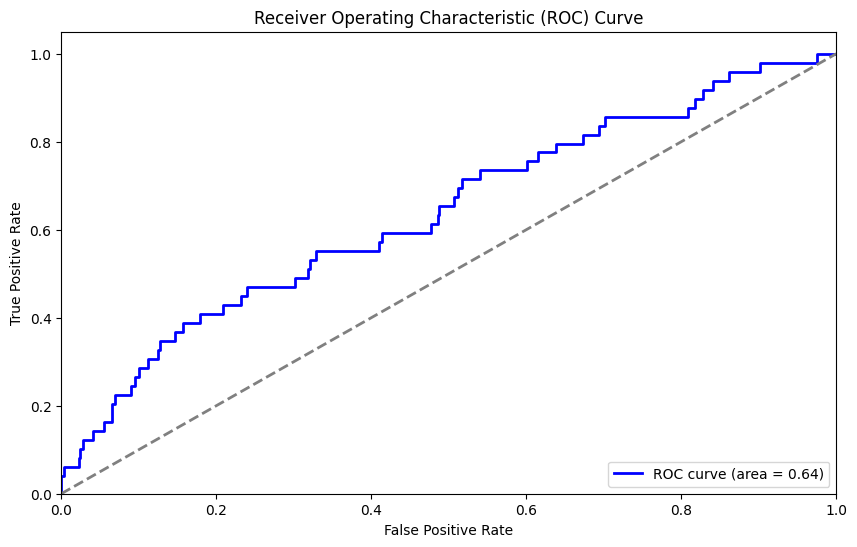

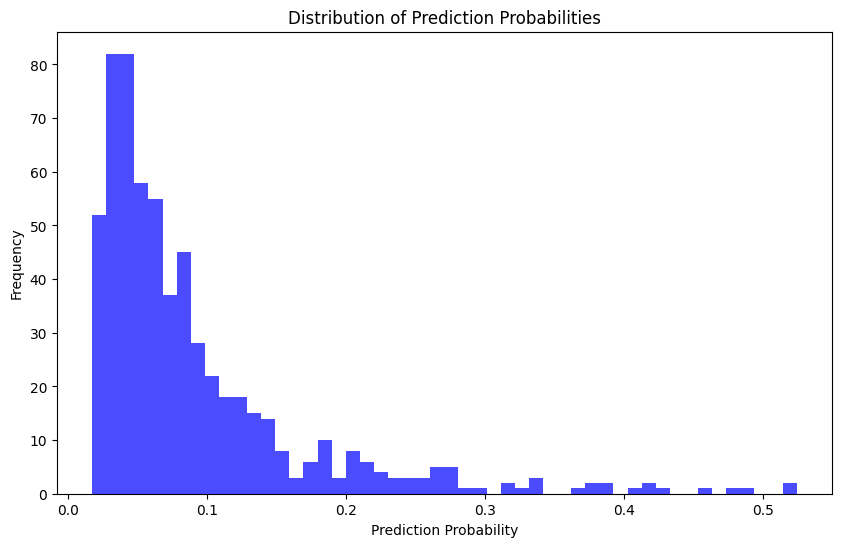

Threshold: 0.0
Confusion Matrix:
[[566   0]
 [ 47   2]]
Precision: 0.07967479674796749
Recall: 1.0
F1 Score: 0.14759036144578314

Threshold: 0.1
Confusion Matrix:
[[566   0]
 [ 47   2]]
Precision: 0.13218390804597702
Recall: 0.46938775510204084
F1 Score: 0.2062780269058296

Threshold: 0.2
Confusion Matrix:
[[566   0]
 [ 47   2]]
Precision: 0.1896551724137931
Recall: 0.22448979591836735
F1 Score: 0.205607476635514

Threshold: 0.30000000000000004
Confusion Matrix:
[[566   0]
 [ 47   2]]
Precision: 0.25
Recall: 0.10204081632653061
F1 Score: 0.14492753623188406

Threshold: 0.4
Confusion Matrix:
[[566   0]
 [ 47   2]]
Precision: 0.3333333333333333
Recall: 0.061224489795918366
F1 Score: 0.10344827586206896

Threshold: 0.5
Confusion Matrix:
[[566   0]
 [ 47   2]]
Precision: 1.0
Recall: 0.04081632653061224
F1 Score: 0.0784313725490196

Threshold: 0.6000000000000001
Confusion Matrix:
[[566   0]
 [ 47   2]]
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Threshold: 0.7000000000000001
Confusion Matrix:

/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

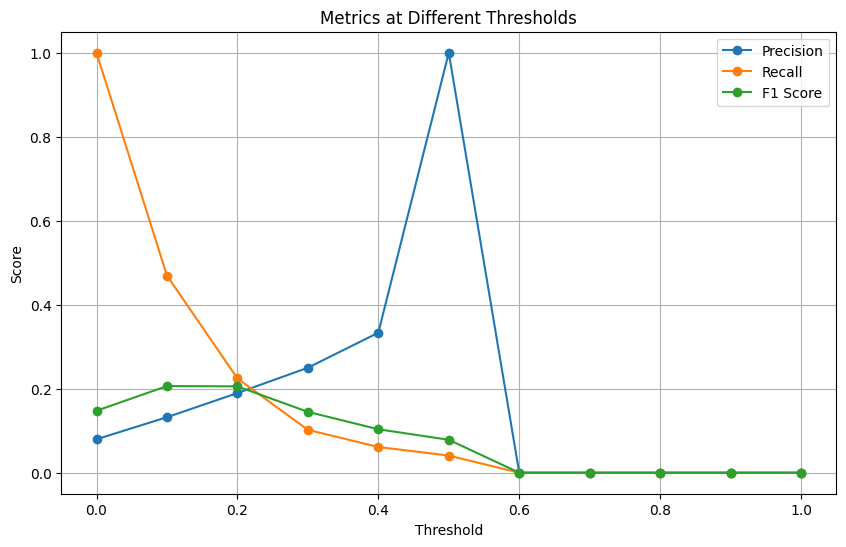

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Charger le modèle sauvegardé
model_path = '../models/best_pipeline_model.pkl'
best_model = joblib.load(model_path)

# Prédire les targets sur X_test_scaled
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculer les métriques de performance
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUC: {auc_score}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Tracer la distribution des probabilités de prédiction
plt.figure(figsize=(10, 6))
plt.hist(y_proba, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.show()

# Analyser l'importance du seuil
thresholds = np.arange(0.0, 1.1, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_adjusted = (y_proba >= threshold).astype(int)
    precision_adjusted = precision_score(y_test, y_pred_adjusted)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    f1_adjusted = f1_score(y_test, y_pred_adjusted)
    
    precisions.append(precision_adjusted)
    recalls.append(recall_adjusted)
    f1_scores.append(f1_adjusted)
    
    print(f"Threshold: {threshold}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision_adjusted}")
    print(f"Recall: {recall_adjusted}")
    print(f"F1 Score: {f1_adjusted}\n")

# Tracer les métriques en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()

cout seuil

## descriptions features

In [109]:
# Charger le fichier de description des colonnes avec l'encodage correct
try:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='utf-8')
except UnicodeDecodeError:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

# Filtrer pour obtenir uniquement les descriptions pertinentes pour les caractéristiques utilisées dans l'application {train|test}
feature_descriptions = columns_description[columns_description['Table'].str.contains('application_{train|test}.csv', na=False)]
feature_descriptions = feature_descriptions[['Row', 'Description']].set_index('Row')


# Feature importance

## globale

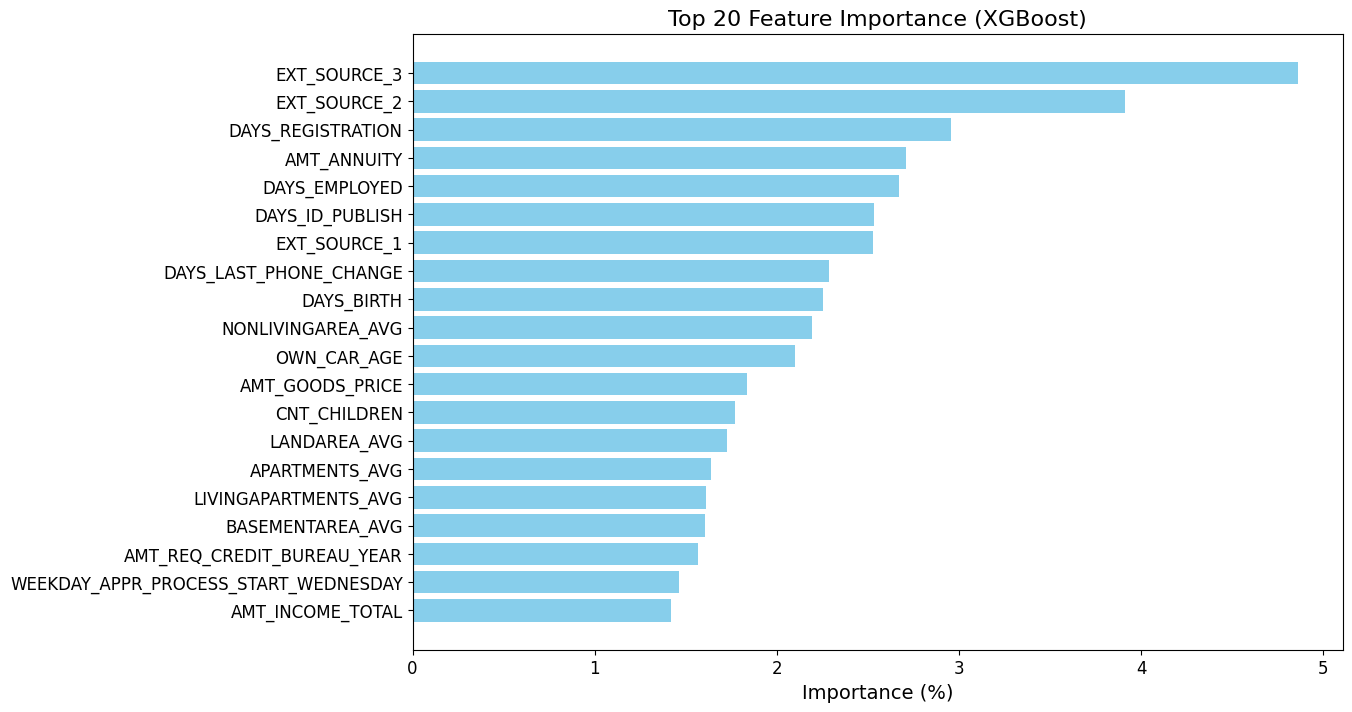

EXT_SOURCE_3: Normalized score from external data source
EXT_SOURCE_2: Normalized score from external data source
DAYS_REGISTRATION: How many days before the application did client change his registration
AMT_ANNUITY: Loan annuity
DAYS_EMPLOYED: How many days before the application the person started current employment
DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan
EXT_SOURCE_1: Normalized score from external data source
DAYS_LAST_PHONE_CHANGE: How many days before application did client change phone
DAYS_BIRTH: Client's age in days at the time of application
NONLIVINGAREA_AVG: Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
OWN_CAR_AGE: Age of client's car
AMT_GOODS_PRICE: For co

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier, plot_importance

# Entraîner le meilleur modèle XGBoost avec les meilleurs hyperparamètres trouvés
# best_model = grid_search.best_estimator_

#ajustement necessaire depuis qu'on utilise pipeline

# Entraîner le meilleur modèle XGBoost avec les meilleurs hyperparamètres trouvés
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['xgb']  # Extraire le modèle XGBoost du pipeline


# Extraire l'importance des caractéristiques
importance = best_model.get_booster().get_score(importance_type='weight')

# Convertir en DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Assigner des noms significatifs aux features basées sur leur ordre dans les données d'origine
feature_names = X_train.columns
importance_df['Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])

# Ajouter les descriptions des caractéristiques
importance_df['Description'] = importance_df['Feature'].map(feature_descriptions['Description'])

# Remplacer les valeurs NaN dans les descriptions par une chaîne vide pour éviter les erreurs
importance_df['Description'] = importance_df['Description'].fillna('')

# Trier les caractéristiques par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Calculer le pourcentage d'importance
importance_df['Importance'] = 100 * (importance_df['Importance'] / importance_df['Importance'].sum())

# Afficher les 20 premières caractéristiques
top_20_features = importance_df.head(20)

plt.figure(figsize=(12, 8))  # Ajustez la taille de la figure pour plus de lisibilité
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance (%)', fontsize=14)
plt.title('Top 20 Feature Importance (XGBoost)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

# Afficher le graphique
plt.show()

# Afficher les descriptions des 20 premières caractéristiques
descriptions = [f"{feature}: {desc}" for feature, desc in zip(top_20_features['Feature'], top_20_features['Description'])]

# Utiliser print pour afficher les descriptions
for description in descriptions:
    print(description)


## locale

Crédit accepté


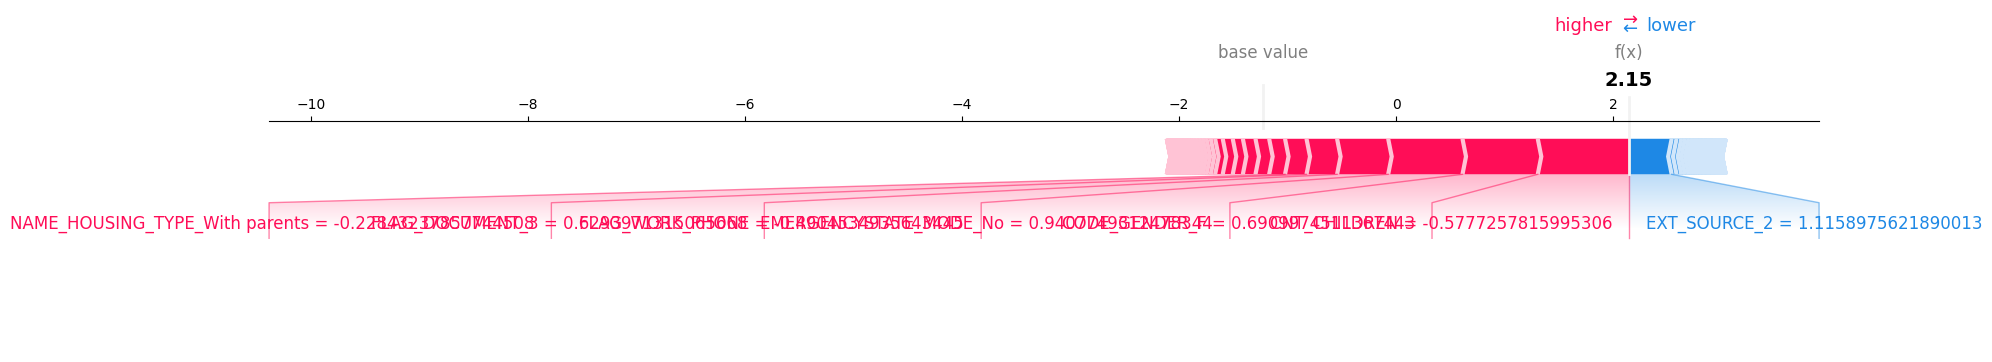

Crédit refusé


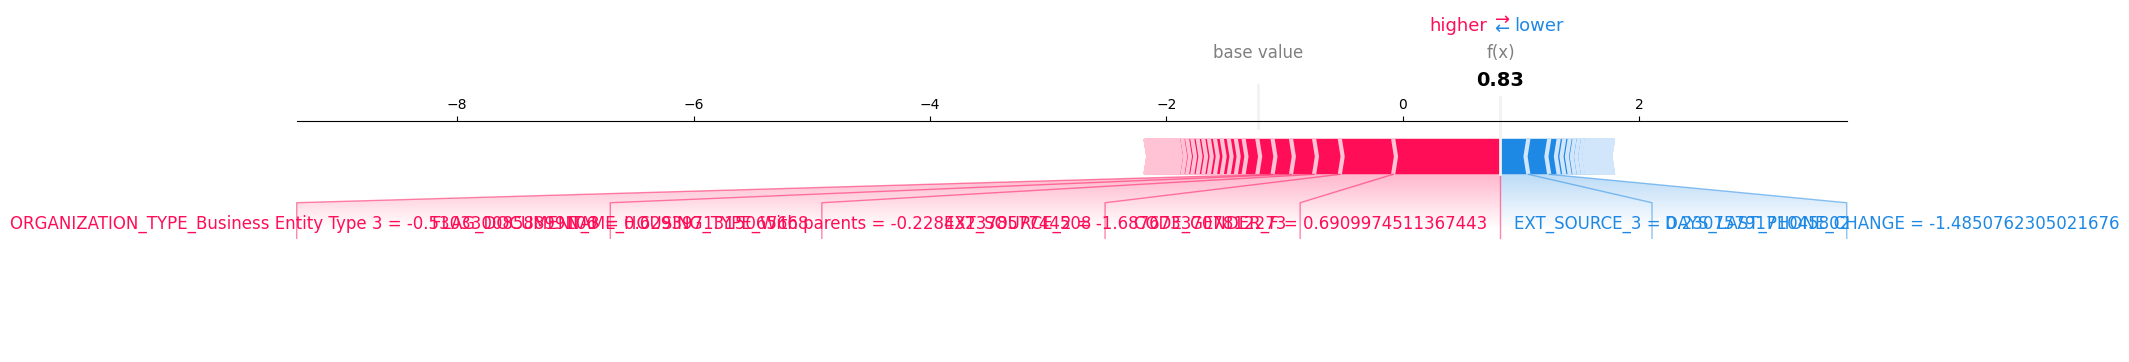

In [111]:
import shap

# Extraire le modèle XGBoost du pipeline
best_model = best_pipeline.named_steps['xgb']  # Extraire le modèle XGBoost du pipeline


# Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.TreeExplainer(best_model)

# Sélectionner un client avec une cible de 0 et un client avec une cible de 1
indices_target_0 = y_test[y_test == 0].index
indices_target_1 = y_test[y_test == 1].index

# Vérifier que les indices existent
if len(indices_target_0) > 0:
    index_target_0 = indices_target_0[0]
    # Convertir l'index global en index relatif
    relative_index_target_0 = y_test.index.get_loc(index_target_0)
    X_target_0 = X_test_scaled[relative_index_target_0].reshape(1, -1)
    shap_values_target_0 = explainer.shap_values(X_target_0)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 0
    print("Crédit accepté")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_0, X_target_0, feature_names=feature_names, matplotlib=True)

if len(indices_target_1) > 0:
    index_target_1 = indices_target_1[0]
    # Convertir l'index global en index relatif
    relative_index_target_1 = y_test.index.get_loc(index_target_1)
    X_target_1 = X_test_scaled[relative_index_target_1].reshape(1, -1)
    shap_values_target_1 = explainer.shap_values(X_target_1)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 1
    print("Crédit refusé")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_1, X_target_1, feature_names=feature_names, matplotlib=True)


# temps de fin d'execution

In [112]:
# Marquer la fin de l'exécution
end_time = time.time()

# Calculer le temps d'exécution total
execution_time = end_time - start_time
execution_time_str = str(datetime.timedelta(seconds=execution_time))

print(f"Exécution du notebook terminée à: {datetime.datetime.now()}")
print(f"Temps d'exécution total: {execution_time_str}")


Exécution du notebook terminée à: 2024-06-29 15:24:54.882999
Temps d'exécution total: 0:01:41.566697


## Recherche id clients


In [117]:
import pandas as pd
import joblib

# Charger le DataFrame
app_datas_imputed_scaled = pd.read_csv('../csv_files/app_datas_light_imputed_scaled.csv')

# Charger le modèle
model = joblib.load("../models/best_xgboost_model.pkl")

# Séparer les features en excluant les colonnes 'TARGET' et 'SK_ID_CURR'
features = app_datas_imputed_scaled.drop(columns=['TARGET', 'SK_ID_CURR'])

# Faire les prédictions de probabilité
probabilities = model.predict_proba(features)

# Ajouter les probabilités au DataFrame
app_datas_imputed_scaled['PREDICTION_PROB'] = probabilities[:, 1]  # Probabilité d'appartenir à la classe 1

# Filtrer pour obtenir 5 clients avec une probabilité de prédiction de 1 la plus élevée
clients_with_highest_prob_1 = app_datas_imputed_scaled.nlargest(5, 'PREDICTION_PROB')

# Filtrer pour obtenir 5 clients avec une probabilité de prédiction de 0 la plus faible
clients_with_lowest_prob_1 = app_datas_imputed_scaled.nsmallest(5, 'PREDICTION_PROB')

# Afficher les résultats
print("Clients avec la plus haute probabilité de prédiction de 1:")
print(clients_with_highest_prob_1[['SK_ID_CURR', 'PREDICTION_PROB']])

print("\nClients avec la plus basse probabilité de prédiction de 1 (donc prédiction de 0):")
print(clients_with_lowest_prob_1[['SK_ID_CURR', 'PREDICTION_PROB']])


Clients avec la plus haute probabilité de prédiction de 1:
      SK_ID_CURR  PREDICTION_PROB
1508      277339         0.996403
679       447007         0.996367
2708      143949         0.995791
1909      437846         0.995168
1536      379960         0.993624

Clients avec la plus basse probabilité de prédiction de 1 (donc prédiction de 0):
      SK_ID_CURR  PREDICTION_PROB
2473      415287         0.000007
2351      268905         0.000008
2082      294180         0.000009
789       143723         0.000009
2512      278231         0.000012
